In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sqlalchemy as db
import csv

from pathlib import Path
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Integer, Table, Column, MetaData
from sklearn.model_selection import train_test_split

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [2]:
# Create SQLite db
restaurants_db = "restaurants.sqlite"
connector = (f"sqlite:///{restaurants_db}")

# Create engine
engine = create_engine(connector)

# Create metadata access to the object
meta_data = db.MetaData(bind=engine)
db.MetaData.reflect(meta_data)

# # Get the tables from the metadata object
# attributes = meta_data.tables["RestaurantAttributes"]
# restaurants = meta_data.tables["Restaurants"]


KeyError: 'RestaurantAttributes'

In [43]:
# Select data into dataframe
sql_join = r"select RestaurantAttributes.*,stars,review_count,is_mexican_restaurant from RestaurantAttributes inner join Restaurants on RestaurantAttributes.business_id = Restaurants.business_id"

restaurants_df = pd.read_sql(sql_join, engine)
# restaurants_df.pop("business_id")
restaurants_df.pop("change_date")
restaurants_df.head()

,business_id,ByAppointmentOnly,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,BikeParking,Alcohol,HasTV,NoiseLevel,Caters,...,BestNightsTypeId,BestNightsType,AlcoholId,NoiseLevelId,WiFiId,SmokingId,BYOBCorkageId,stars,review_count,is_mexican_restaurant
0,XOSRcvtaKc_Q5H1SAzN20A,0,0,0,1,0,no,0,no,0,...,0,na,1,1,1,1,1,4.5,3,0
1,l09JfMeQ6ynYs5MCJtrcmQ,0,0,0,0,0,no,0,no,0,...,0,na,1,1,1,1,1,3.0,12,0
2,gAy4LYpsScrj8POnCW6btQ,0,0,0,0,0,no,0,no,0,...,0,na,1,1,1,1,1,3.5,6,0
3,1_3nOM7s9WqnJWTNu2-i8Q,0,0,1,0,0,no,0,no,0,...,0,na,1,1,1,1,1,3.0,8,0
4,BnuzcebyB1AfxH0kjNWqSg,0,0,0,1,0,no,0,no,0,...,0,na,1,1,1,1,1,3.5,25,0


In [44]:
restaurants_df.dtypes

business_id                    object
ByAppointmentOnly               int64
BusinessAcceptsCreditCards      int64
GoodForKids                     int64
WheelchairAccessible            int64
BikeParking                     int64
Alcohol                        object
HasTV                           int64
NoiseLevel                     object
Caters                          int64
WiFi                           object
HappyHour                       int64
GoodForDancing                  int64
OutdoorSeating                  int64
CoatCheck                       int64
Smoking                        object
DriveThru                       int64
BYOBCorkage                    object
BusinessParkingTypeId           int64
BusinessParkingType            object
MusicTypeId                     int64
MusicType                      object
RestaurantsTypeId               int64
RestaurantsType                object
GoodForMealTypeId               int64
GoodForMealType                object
DietaryRestr

In [45]:
with pd.option_context('display.max_rows', None,):
    print(restaurants_df.nunique())

for col in restaurants_df:
    print(f"Name: {col} | Values: {restaurants_df[col].unique()}")

business_id                   13848
ByAppointmentOnly                 2
BusinessAcceptsCreditCards        2
GoodForKids                       2
WheelchairAccessible              2
BikeParking                       2
Alcohol                           4
HasTV                             2
NoiseLevel                        4
Caters                            2
WiFi                              3
HappyHour                         2
GoodForDancing                    2
OutdoorSeating                    2
CoatCheck                         2
Smoking                           3
DriveThru                         2
BYOBCorkage                       3
BusinessParkingTypeId             6
BusinessParkingType               6
MusicTypeId                       3
MusicType                         3
RestaurantsTypeId                 6
RestaurantsType                   6
GoodForMealTypeId                 7
GoodForMealType                   7
DietaryRestrictionsTypeId         3
DietaryRestrictionsType     

In [46]:
# drop string cols - they're already encoded in the id cols
#show all columns that have a class of object (i.e. string)
string_cols = restaurants_df.select_dtypes(include=["object"]).columns.tolist()
string_cols = string_cols[1:]
string_cols

restaurants_df.drop(string_cols, axis=1, inplace=True)
restaurants_df.dtypes

,business_id,ByAppointmentOnly,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,BikeParking,HasTV,Caters,HappyHour,GoodForDancing,...,DietaryRestrictionsTypeId,BestNightsTypeId,AlcoholId,NoiseLevelId,WiFiId,SmokingId,BYOBCorkageId,stars,review_count,is_mexican_restaurant
0,XOSRcvtaKc_Q5H1SAzN20A,0,0,0,1,0,0,0,0,0,...,0,0,1,1,1,1,1,4.5,3,0
1,l09JfMeQ6ynYs5MCJtrcmQ,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,3.0,12,0
2,gAy4LYpsScrj8POnCW6btQ,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,3.5,6,0
3,1_3nOM7s9WqnJWTNu2-i8Q,0,0,1,0,0,0,0,0,0,...,0,0,1,1,1,1,1,3.0,8,0
4,BnuzcebyB1AfxH0kjNWqSg,0,0,0,1,0,0,0,0,0,...,0,0,1,1,1,1,1,3.5,25,0


In [50]:
print(restaurants_df.stars.value_counts())
restaurants_df.stars.describe()

3.5    3581
4.0    3194
3.0    2950
2.5    1485
4.5    1363
2.0     678
5.0     333
1.5     209
1.0      55
Name: stars, dtype: int64


count    13848.000000
mean         3.422516
std          0.748382
min          1.000000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: stars, dtype: float64

In [51]:
columns = restaurants_df.columns.values.tolist()
columns.remove("stars")

target = ["stars"]

3.5    3581
4.0    3194
3.0    2950
2.5    1485
4.5    1363
2.0     678
5.0     333
1.5     209
1.0      55
Name: stars, dtype: int64


<AxesSubplot:ylabel='Density'>

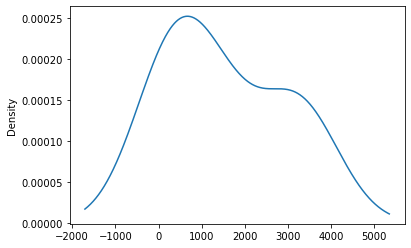

In [54]:
# Visualize the value counts of stars
stars_counts = restaurants_df.stars.value_counts()
print(stars_counts)

stars_counts.plot.density()